In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import functools
import scipy
from collections import namedtuple

## Global parameters for the analysis

In [2]:
# Set random seed
seed = 1241489141
np.random.seed(seed)

In [3]:
Ndat = 100
x_range = [-1,1]
test_function = scipy.special.legendre(3)
add_noise = False

In [4]:
# Generate Data
x = np.linspace(-1, 1, 100)  # Input data
y_true = test_function(x) #np.sin(x)  # True function
noise = np.random.normal(0, 0.1, size=y_true.shape)  # Adding some noise

if add_noise:
  y_noisy = y_true + noise
else:
  y_noisy = y_true

Defining function that creates the model

In [5]:
def generate_sequential_model(outputs=1, 
                   input_layer=None, 
                   nlayers=2, 
                   units=[100,100],
                   seed=seed,
                   **kwargs):
  """
  Create a tensorflow sequential model where all intermediate layers have the same size
  This function accepts an already constructed layer as the input.

  All hidden layers will have the same number of nodes for simplicity

  Arguments:
      outputs: int (default=1)
          number of output nodes (how many flavours are we training)
      input_layer: KerasTensor (default=None)
          if given, sets the input layer of the sequential model
      nlayers: int
          number of hidden layers of the network
      units: int
          number of nodes of every hidden layer in the network
      activation: str
          activation function to be used by the hidden layers (ex: 'tanh', 'sigmoid', 'linear')
  """
  if len(units) != nlayers:
      raise Exception("The length of units must match the number of layers.")
  
  if kwargs.get('kernel_initializer'):
      kernel_initializer = kwargs['kernel_initializer']
  else:
      kernel_initializer = tf.keras.initializers.HeNormal

  if kwargs.get('activation_list'):
      activation_list = kwargs['activation_list']
      if len(units) != len(activation_list):
          raise Exception("The length of the activation list must match the number of layers.")
  else:
      activation_list = ['tanh', 'tanh']

  if kwargs.get('output_func'):
      output_func = kwargs['output_func']
  else:
      output_func = 'linear'
      
  
  model = tf.keras.models.Sequential(name="pdf")
  if input_layer is not None:
      model.add(input_layer)
  for layer in range(nlayers):
      model.add(tf.keras.layers.Dense(units[layer], 
                                      activation=activation_list[layer],
                                      kernel_initializer=kernel_initializer(seed=seed - layer),
                                      ),
      )
  model.add(tf.keras.layers.Dense(outputs, 
                                  activation=output_func, 
                                  kernel_initializer=tf.keras.initializers.HeNormal(seed=seed - nlayers)
                                  ))

  return model

## Training parameters

In [6]:
# Custom Callback for TQDM progress bar
class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc="Training", unit="epoch")
    
    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)
    
    def on_train_end(self, logs=None):
        self.progress_bar.close()

In [7]:
# Step 3: Compile the model with pure Gradient Descent
learning_rate=0.01
epochs = 1000
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)  # Gradient Descent optimizer
# in alternative optmizer = 'adam'

# To be used as
# model.compile(optimizer=optimizer, loss='mse')  # MSE for regression
# history = model.fit(x, y_noisy, epochs=epochs, batch_size=len(x), verbose=0,
#                    callbacks=[TQDMProgressBar()])  # Full batch size (no mini-batches)

## Defining function the computes the NTK given the model and the input

In [8]:
def compute_ntk(model, input):
    grad = []
    for x in tf.convert_to_tensor(input):
        with tf.GradientTape() as tape:
            x = tf.reshape(x, shape=(-1,1))
            #tape.watch(x)
            pred = model(x)

        # compute gradients df(x)/dtheta
        g = tape.gradient(pred, model.trainable_variables)
        # concatenate the gradients of all trainable variables,
        # not discriminating between weights and biases
        g = tf.concat([tf.reshape(i, shape=(-1,1)) for i in g], axis=0)
        grad.append(g)

    grad = tf.concat(grad,axis=1)
    ntk = tf.einsum('ij,ik->jk', grad, grad)
    return ntk

# Defining function that implements the integrated solution

The function refers to the following integrated solution
$$
  T(t) = T(0) + \left( \mathbb{I} - e^{-\Theta \, \eta \, t} \right) \, (y - T(0)) \,,
$$
where $T(t)$ are predictions at training-time $t$, $\Theta$ is the NTK, and $\eta$ is the learning rate. Finally, $y$ is the vector of targets we would use to train the network. We are interested in decomposing the integrated expression into the eigenspace specified by the NTK. Hence, the predictions at time $t$ will be the sum of different components, which are the projections in the NTK basis.
$$
T(t) = \sum_{k=1}^{\textrm{eig}(\Theta)} \widetilde{T}_0^{(k)} \, v^{(k)} 
+ \sum_{k=1}^{\textrm{eig}(\Theta)} \left( 1 - e^{-\lambda^{(k)} \, \eta \, t} \right) \, (\widetilde{y}^{(k)} - \widetilde{T}_0^{(k)}) \, v^{(k)} \,,
$$
where $v^{(k)}$ is the $k$-th eigenvector relative to the eigenvalue $\lambda^{(k)}$ of the NTK. Quantities decorated with a tilde are the components in the NTK basis of the original vector, for instance
$$
\widetilde{T}_0^{(k)} = T(0) \cdot v^{(k)} \,.
$$
The function returns an array containing the different components and the relative eigenvector, as well as the sum of all components as shown in the equation above.

In [9]:
def f(t, model, input, learning_rate):
  ntk = compute_ntk(model, input).numpy()
  f0 = model(x)
  f0 = f0.numpy().reshape((f0.numpy().shape[0],))
  
  I = np.identity(x.size)
  eTheta_t = scipy.linalg.expm(- ntk * learning_rate * t)
  err = np.add(f0, - y_noisy)
  return f0 - (I - eTheta_t) @ err, f0

def ntk_decomposition(t, model, input, learning_rate):
  ntk = compute_ntk(model, input).numpy()
  ntk = 0.5 * (ntk.T + ntk)
  f0 = model(x)
  f0 = f0.numpy().reshape((f0.numpy().shape[0],))
  
  eigval, eigvec = np.linalg.eig(ntk)

  f0_tilde = [np.dot(f0, eigvec[:, k]) for k in range(eigval.size)]
  y_tilde = [np.dot(y_noisy, eigvec[:, k]) for k in range(eigval.size)]
  
  sum = np.zeros_like(eigvec[:,0])
  components_tuple = namedtuple('components_tuple', ['Coefficient', 'Eigenvector', 'Eigenvalue'])
  aux = []
  for k in range(eigval.size):
    coeff1 = f0_tilde[k] 
    coeff2 = (1 - np.exp(- eigval[k] * learning_rate * t) ) * (y_tilde[k] - f0_tilde[k])
    sum = np.add(sum, (coeff1 + coeff2) * eigvec[:,k])
    aux.append(coeff1 + coeff2)

  components = components_tuple(
    Coefficient=aux, Eigenvector=eigvec, Eigenvalue=eigval
  )

  return components, sum

## Plotting the sum of the NTK components at training-time $t$

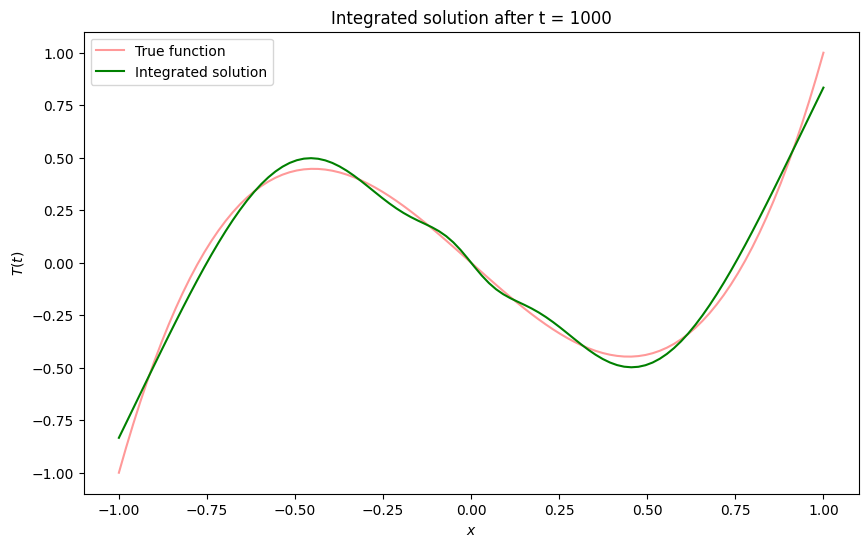

In [10]:
t = 1000
model = generate_sequential_model(outputs=1, units=[28,20])
_, T_t = ntk_decomposition(t, model, x, learning_rate)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, y_noisy, label="True function", color='red', alpha=0.4)
ax.plot(x, T_t, color='green', label='Integrated solution')
ax.set_title(f"Integrated solution after t = {t}")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$T(t)$')
ax.legend()

## Comparison of the integrated solution with different architectures at the same training-time

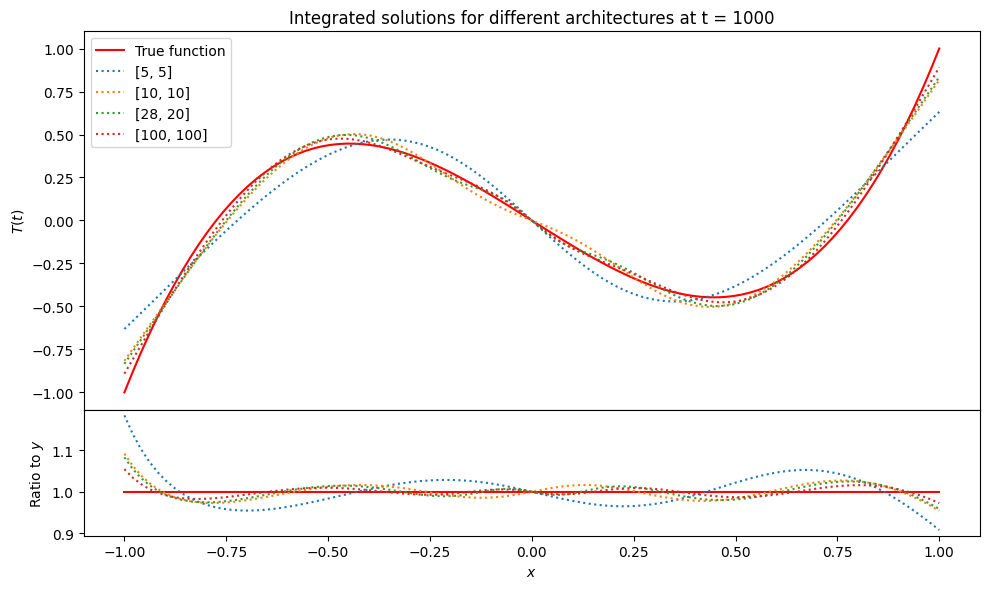

In [11]:
t = 1000
learning_rate = 0.01
architectures = [
  [5,5],
  [10,10],
  [28,20],
  [100,100]
]

shift = 3
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(10,6), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})
ax1.plot(x, y_noisy, label="True function", color='red')
ax2.plot(x, [1 for _ in range(x.size)], color='red')

for arch in architectures:
  model = generate_sequential_model(outputs=1, units=arch)
  _, T_t = ntk_decomposition(t, model, x, learning_rate)
  ax1.plot(x, T_t, label=str(arch),  linestyle='dotted')
  ax2.plot(x, (T_t + shift) / (y_noisy + shift ),  linestyle='dotted')


ax1.set_title(f"Integrated solutions for different architectures at t = {t}")
ax2.set_xlabel(r'$x$')
ax1.set_ylabel(r'$T(t)$')
ax2.set_ylabel(r'Ratio to $y$')
ax1.legend()
plt.tight_layout()

## Break-down of components using a NNPDF-like architecture

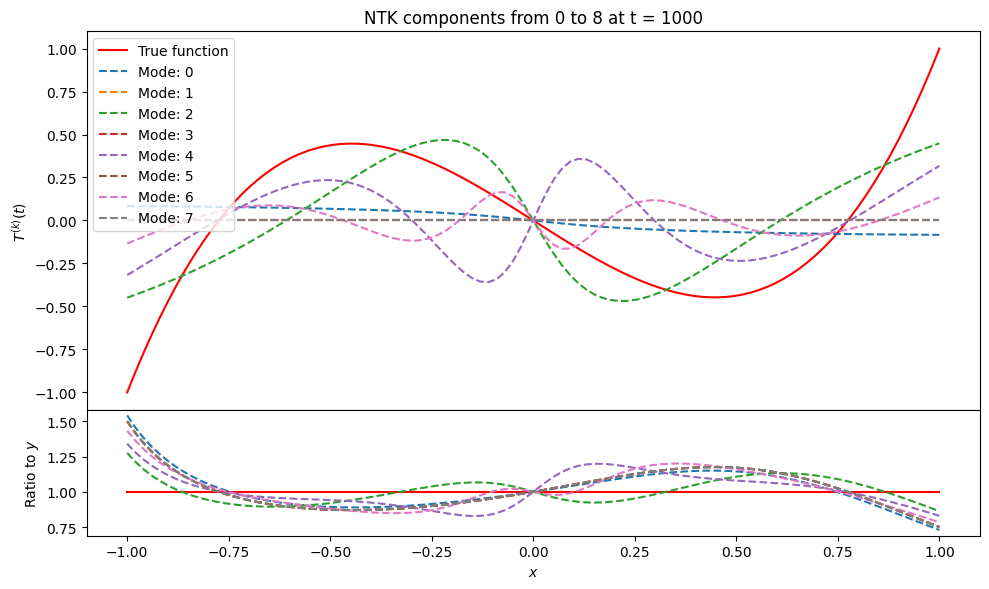

In [12]:
t = 1000

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(10,6), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})
ax1.plot(x, y_noisy, label="True function", color='red')
ax2.plot(x, [1 for _ in range(x.size)], color='red')
model = generate_sequential_model(outputs=1, units=[28,20])
components, T_t = ntk_decomposition(t, model, x, learning_rate)

shift = 3
start = 0
end = 8

eigvals = components.Eigenvalue
eigvecs = components.Eigenvector
coeffs = components.Coefficient
for comp in range(start, end, 1):
  ax1.plot(x, coeffs[comp] * eigvecs[:,comp], label=f"Mode: {comp}", linestyle='dashed')
  ax2.plot(x, (shift + coeffs[comp] * eigvecs[:,comp]) / (y_noisy  + shift),  linestyle='dashed')


ax1.set_title(f"NTK components from {start} to {end} at t = {t}")
ax2.set_xlabel(r'$x$')
ax1.set_ylabel(r'$T^{(k)}(t)$')
ax2.set_ylabel(r'Ratio to $y$')
ax1.legend()
plt.tight_layout()

## Plotting NTK coefficients in function of the training-time

In [13]:
import random

class ColorGenerator:
    def __init__(self):
        self.colors = set()  # To store previously generated colors

    def generate_color(self):
        while True:
            # Generate random RGB values
            r = random.randint(0, 255)
            g = random.randint(0, 255)
            b = random.randint(0, 255)

            # Convert RGB to hexadecimal
            hex_color = f'#{r:02x}{g:02x}{b:02x}'

            # Check if the color has already been generated
            if hex_color not in self.colors:
                self.colors.add(hex_color)  # Add the new color to the set
                return hex_color

Here I study the coefficients of the expansion in the NTK basis in function of the training time $t$. The coefficients are defined as follows
$$
c_k(t) = \widetilde{T}_0^{(k)} + \left( 1 - e^{-\eta \; \lambda_k \; t} \right) (\widetilde{y}^{(k)} - \widetilde{T}_0^{(k)}) \,.
$$
The coefficients are then normalised to $\widetilde{T}_0^{(k)}$, so that all curves start from $1$.

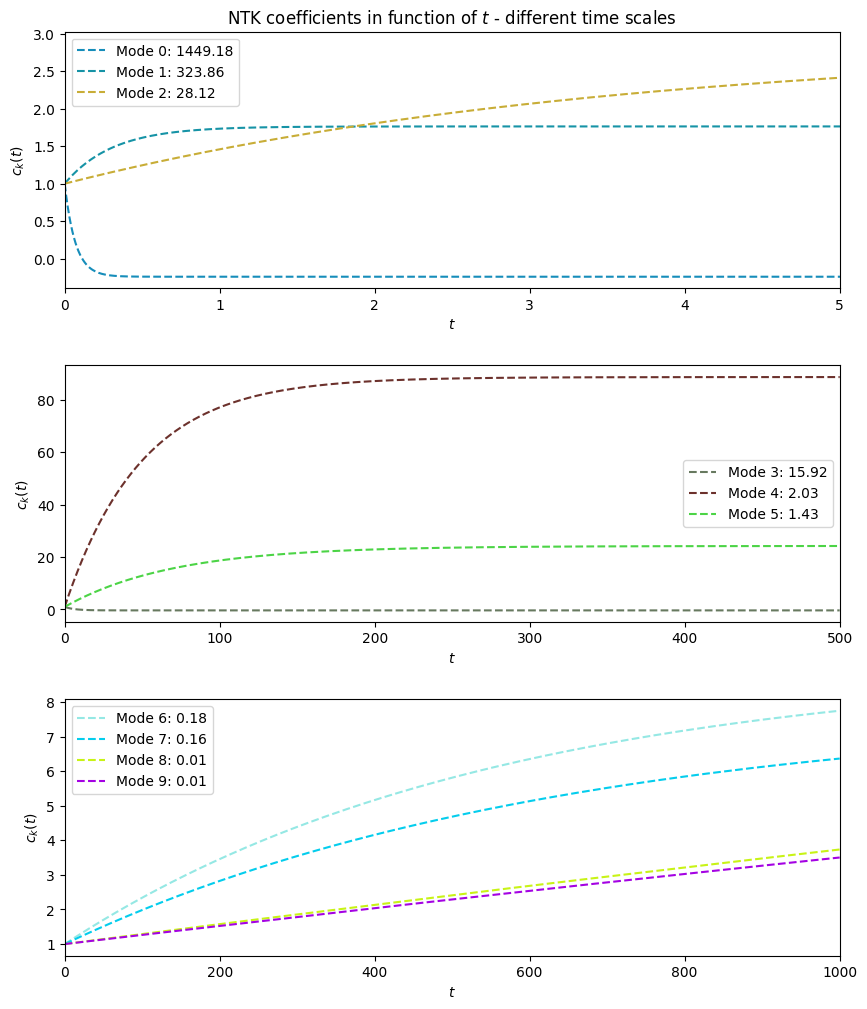

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False ,figsize=(10,12), gridspec_kw={'height_ratios': [1, 1, 1], 'hspace':0.3})
model = generate_sequential_model(outputs=1, units=[28,20])

training_steps = np.arange(0, 1000, 0.01)
color_generator = ColorGenerator()

# Compute NTK, output at initialisation, and eigensystem
ntk = compute_ntk(model, x).numpy()
ntk = 0.5 * (ntk.T + ntk)
f0 = model(x)
f0 = f0.numpy().reshape((f0.numpy().shape[0],))

eigval, eigvec = np.linalg.eig(ntk)

f0_tilde = np.array([np.dot(f0, eigvec[:, k]) for k in range(eigval.size)])
y_tilde = np.array([np.dot(y_noisy, eigvec[:, k]) for k in range(eigval.size)])

def coeff(t):
  coeff1 = f0_tilde
  coeff2 = (1 - np.exp(- eigval * learning_rate * t) ) * (y_tilde - f0_tilde)
  return (coeff1 + coeff2) / f0_tilde

coeff_t = np.array([coeff(t) for t in training_steps])

start = 0
end = 3
for k in range(start, end, 1):
  ax1.plot(training_steps, coeff_t[:,k], color=color_generator.generate_color(), label=f"Mode {k}: {eigval[k]:.2f}", linestyle='dashed')
  ax1.set_xlim([0,5])

start = 3
end = 6
for k in range(start, end, 1):
  ax2.plot(training_steps, coeff_t[:,k], color=color_generator.generate_color(), label=f"Mode {k}: {eigval[k]:.2f}", linestyle='dashed')
  ax2.set_xlim([0,500])

start = 6
end = 10
for k in range(start, end, 1):
  ax3.plot(training_steps, coeff_t[:,k], color=color_generator.generate_color(), label=f"Mode {k}: {eigval[k]:.2f}", linestyle='dashed')
  ax3.set_xlim([0,1000])

ax1.set_title(fr"NTK coefficients in function of $t$ - different time scales")
ax1.set_xlabel(r'$t$')
ax2.set_xlabel(r'$t$')
ax3.set_xlabel(r'$t$')
ax1.set_ylabel(r'$c_{k}(t)$')
ax2.set_ylabel(r'$c_{k}(t)$')
ax3.set_ylabel(r'$c_{k}(t)$')
ax1.legend()
ax2.legend()
ax3.legend()

